In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import re

# Funzione per estrarre e convertire i valori dell'ottava colonna in liste di float
def get_eight_column_values(df, type_val, module_val, name_val):
    filtered_df = df[(df['type'] == type_val) & (df['module'] == module_val) & (df['name'] == name_val)]
    if filtered_df.empty:
        return None
    values = filtered_df.iloc[:, 7].str.split().apply(lambda x: list(map(float, x)))
    return values.explode().astype(float).values

# Funzione per estrarre e convertire i valori della settima colonna in liste di float
def get_seventh_column_values(df, type_val, module_val, name_val):
    filtered_df = df[(df['type'] == type_val) & (df['module'] == module_val) & (df['name'] == name_val)]
    if filtered_df.empty:
        return None
    values = filtered_df.iloc[:, 6].str.split().apply(lambda x: list(map(float, x)))
    return values.explode().astype(float).values

# Funzione per calcolare l'intervallo di confidenza t-student
def t_student_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    margin = sem * stats.t.ppf((1 + confidence) / 2, len(data) - 1)
    return mean, mean - margin, mean + margin

# Funzione per calcolare l'intervallo di confidenza naive
def naive_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    margin = mean * (1 - confidence)
    return mean, mean - margin, mean + margin

# Funzione per calcolare l'intervallo di confidenza normale
def normal_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std_error = stats.sem(data)  # Standard error of the mean
    z_value = stats.norm.ppf(1 - (1 - confidence) / 2)
    margin = z_value * std_error
    return mean, mean - margin, mean + margin

# Funzione per rimuovere '_vec' dalla fine del nome del file
def remove_vec_suffix(file_name):
    if file_name.endswith('_vec.csv'):
        return file_name[:-8]
    else:
        return file_name

# Funzione per ottenere il numero finale dal nome del file
def get_file_number(file_name):
    match = re.search(r'\d+$', file_name)
    if match:
        return int(match.group())
    else:
        return 0  # Se non viene trovato nessun numero, restituisci 0

# Funzione per analizzare un singolo file CSV
def analyze_csv(file_path, ignored_files, results):
    df = pd.read_csv(file_path)
    description = df[df['attrname'] == 'description']['attrvalue'].values
    description = description[0] if len(description) > 0 else "N/A"

    is_N = any("N=1" in val for val in df[df['attrname'] == 'description']['attrvalue'].values)

    pDistribution = get_eight_column_values(df, "vector", "TandemQueueSystem.Server", "pDistribution")
    vDistribution = get_eight_column_values(df, "vector", "TandemQueueSystem.Server", "vDistribution")
    lifeTime = get_eight_column_values(df, "vector", "TandemQueueSystem.sink", "lifeTime:vector")
    lifeTime_arrival = get_seventh_column_values(df, "vector", "TandemQueueSystem.sink", "lifeTime:vector")

    if pDistribution is None or vDistribution is None or lifeTime is None:
        ignored_files.append((remove_vec_suffix(os.path.basename(file_path)), description))
        return

    min_length = min(len(pDistribution), len(vDistribution), len(lifeTime))
    pDistribution = pDistribution[:min_length]
    vDistribution = vDistribution[:min_length]
    lifeTime = lifeTime[:min_length]

    queueLength_Q1 = get_eight_column_values(df, "vector", "TandemQueueSystem.Q1", "queueLength:vector")
    queueLength_Q2 = get_eight_column_values(df, "vector", "TandemQueueSystem.Q2", "queueLength:vector")

    if is_N:
        queueLength_Q2 = np.zeros(len(queueLength_Q1))
    else: 
        if queueLength_Q1 is None or queueLength_Q2 is None:
            ignored_files.append((remove_vec_suffix(os.path.basename(file_path)), description))
            return

    Cw = 1  # Definisci il valore di Cw

    conf_levels = [0.95, 0.90, 0.85, 0.80]
    lifeTime_stats_t_student = {}
    U_values_stats_t_student = {}
    utilization_Q1_stats_t_student = {}
    utilization_Q2_stats_t_student = {}

    lifeTime_stats_naive = {}
    U_values_stats_naive = {}
    utilization_Q1_stats_naive = {}
    utilization_Q2_stats_naive = {}
    
    lifeTime_stats_normal = {}
    U_values_stats_normal = {}
    utilization_Q1_stats_normal = {}
    utilization_Q2_stats_normal = {}

    for conf in conf_levels:
        # Calcoli t-student
        mean_W_t, ci_low_W_t, ci_high_W_t = t_student_confidence_interval(lifeTime, confidence=conf)
        lifeTime_stats_t_student[conf] = (mean_W_t, ci_low_W_t, ci_high_W_t)
        
        U_values = vDistribution - pDistribution - (Cw * lifeTime)
        mean_U_t, ci_low_U_t, ci_high_U_t = t_student_confidence_interval(U_values, confidence=conf)
        U_values_stats_t_student[conf] = (mean_U_t, ci_low_U_t, ci_high_U_t)

        mean_utilization_Q1_t, ci_low_utilization_Q1_t, ci_high_utilization_Q1_t = t_student_confidence_interval(queueLength_Q1 / np.sum(queueLength_Q1), confidence=conf)
        utilization_Q1_stats_t_student[conf] = (mean_utilization_Q1_t, ci_low_utilization_Q1_t, ci_high_utilization_Q1_t)

        mean_utilization_Q2_t, ci_low_utilization_Q2_t, ci_high_utilization_Q2_t = t_student_confidence_interval(queueLength_Q2 / np.sum(queueLength_Q2), confidence=conf)
        utilization_Q2_stats_t_student[conf] = (mean_utilization_Q2_t, ci_low_utilization_Q2_t, ci_high_utilization_Q2_t)

        # Calcoli naive
        mean_W_n, ci_low_W_n, ci_high_W_n = naive_confidence_interval(lifeTime, confidence=conf)
        lifeTime_stats_naive[conf] = (mean_W_n, ci_low_W_n, ci_high_W_n)
        
        mean_U_n, ci_low_U_n, ci_high_U_n = naive_confidence_interval(U_values, confidence=conf)
        U_values_stats_naive[conf] = (mean_U_n, ci_low_U_n, ci_high_U_n)

        mean_utilization_Q1_n, ci_low_utilization_Q1_n, ci_high_utilization_Q1_n = naive_confidence_interval(queueLength_Q1 / np.sum(queueLength_Q1), confidence=conf)
        utilization_Q1_stats_naive[conf] = (mean_utilization_Q1_n, ci_low_utilization_Q1_n, ci_high_utilization_Q1_n)

        mean_utilization_Q2_n, ci_low_utilization_Q2_n, ci_high_utilization_Q2_n = naive_confidence_interval(queueLength_Q2 / np.sum(queueLength_Q2), confidence=conf)
        utilization_Q2_stats_naive[conf] = (mean_utilization_Q2_n, ci_low_utilization_Q2_n, ci_high_utilization_Q2_n)

        # Calcoli normale
        mean_W_norm, ci_low_W_norm, ci_high_W_norm = normal_confidence_interval(lifeTime, confidence=conf)
        lifeTime_stats_normal[conf] = (mean_W_norm, ci_low_W_norm, ci_high_W_norm)
        
        mean_U_norm, ci_low_U_norm, ci_high_U_norm = normal_confidence_interval(U_values, confidence=conf)
        U_values_stats_normal[conf] = (mean_U_norm, ci_low_U_norm, ci_high_U_norm)

        mean_utilization_Q1_norm, ci_low_utilization_Q1_norm, ci_high_utilization_Q1_norm = normal_confidence_interval(queueLength_Q1 / np.sum(queueLength_Q1), confidence=conf)
        utilization_Q1_stats_normal[conf] = (mean_utilization_Q1_norm, ci_low_utilization_Q1_norm, ci_high_utilization_Q1_norm)

        mean_utilization_Q2_norm, ci_low_utilization_Q2_norm, ci_high_utilization_Q2_norm = normal_confidence_interval(queueLength_Q2 / np.sum(queueLength_Q2), confidence=conf)
        utilization_Q2_stats_normal[conf] = (mean_utilization_Q2_norm, ci_low_utilization_Q2_norm, ci_high_utilization_Q2_norm)

    max_W = np.max(lifeTime)
    min_W = np.min(lifeTime)

    results.append({
        "File": remove_vec_suffix(os.path.basename(file_path)),
        "File_Number": get_file_number(remove_vec_suffix(os.path.basename(file_path))),
        "Description": description,
        "max_W": max_W,
        "min_W": min_W,
        **{f"mean_W_t_student_{int(conf*100)}": lifeTime_stats_t_student[conf][0] for conf in conf_levels},
        **{f"ci_low_W_t_student_{int(conf*100)}": lifeTime_stats_t_student[conf][1] for conf in conf_levels},
        **{f"ci_high_W_t_student_{int(conf*100)}": lifeTime_stats_t_student[conf][2] for conf in conf_levels},
        **{f"mean_U_t_student_{int(conf*100)}": U_values_stats_t_student[conf][0] for conf in conf_levels},
        **{f"ci_low_U_t_student_{int(conf*100)}": U_values_stats_t_student[conf][1] for conf in conf_levels},
        **{f"ci_high_U_t_student_{int(conf*100)}": U_values_stats_t_student[conf][2] for conf in conf_levels},
        **{f"mean_utilization_Q1_t_student_{int(conf*100)}": utilization_Q1_stats_t_student[conf][0] for conf in conf_levels},
        **{f"ci_low_utilization_Q1_t_student_{int(conf*100)}": utilization_Q1_stats_t_student[conf][1] for conf in conf_levels},
        **{f"ci_high_utilization_Q1_t_student_{int(conf*100)}": utilization_Q1_stats_t_student[conf][2] for conf in conf_levels},
        **{f"mean_utilization_Q2_t_student_{int(conf*100)}": utilization_Q2_stats_t_student[conf][0] for conf in conf_levels},
        **{f"ci_low_utilization_Q2_t_student_{int(conf*100)}": utilization_Q2_stats_t_student[conf][1] for conf in conf_levels},
        **{f"ci_high_utilization_Q2_t_student_{int(conf*100)}": utilization_Q2_stats_t_student[conf][2] for conf in conf_levels},
        **{f"mean_W_naive_{int(conf*100)}": lifeTime_stats_naive[conf][0] for conf in conf_levels},
        **{f"ci_low_W_naive_{int(conf*100)}": lifeTime_stats_naive[conf][1] for conf in conf_levels},
        **{f"ci_high_W_naive_{int(conf*100)}": lifeTime_stats_naive[conf][2] for conf in conf_levels},
        **{f"mean_U_naive_{int(conf*100)}": U_values_stats_naive[conf][0] for conf in conf_levels},
        **{f"ci_low_U_naive_{int(conf*100)}": U_values_stats_naive[conf][1] for conf in conf_levels},
        **{f"ci_high_U_naive_{int(conf*100)}": U_values_stats_naive[conf][2] for conf in conf_levels},
        **{f"mean_utilization_Q1_naive_{int(conf*100)}": utilization_Q1_stats_naive[conf][0] for conf in conf_levels},
        **{f"ci_low_utilization_Q1_naive_{int(conf*100)}": utilization_Q1_stats_naive[conf][1] for conf in conf_levels},
        **{f"ci_high_utilization_Q1_naive_{int(conf*100)}": utilization_Q1_stats_naive[conf][2] for conf in conf_levels},
        **{f"mean_utilization_Q2_naive_{int(conf*100)}": utilization_Q2_stats_naive[conf][0] for conf in conf_levels},
        **{f"ci_low_utilization_Q2_naive_{int(conf*100)}": utilization_Q2_stats_naive[conf][1] for conf in conf_levels},
        **{f"ci_high_utilization_Q2_naive_{int(conf*100)}": utilization_Q2_stats_naive[conf][2] for conf in conf_levels},
        **{f"mean_W_normal_{int(conf*100)}": lifeTime_stats_normal[conf][0] for conf in conf_levels},
        **{f"ci_low_W_normal_{int(conf*100)}": lifeTime_stats_normal[conf][1] for conf in conf_levels},
        **{f"ci_high_W_normal_{int(conf*100)}": lifeTime_stats_normal[conf][2] for conf in conf_levels},
        **{f"mean_U_normal_{int(conf*100)}": U_values_stats_normal[conf][0] for conf in conf_levels},
        **{f"ci_low_U_normal_{int(conf*100)}": U_values_stats_normal[conf][1] for conf in conf_levels},
        **{f"ci_high_U_normal_{int(conf*100)}": U_values_stats_normal[conf][2] for conf in conf_levels},
        **{f"mean_utilization_Q1_normal_{int(conf*100)}": utilization_Q1_stats_normal[conf][0] for conf in conf_levels},
        **{f"ci_low_utilization_Q1_normal_{int(conf*100)}": utilization_Q1_stats_normal[conf][1] for conf in conf_levels},
        **{f"ci_high_utilization_Q1_normal_{int(conf*100)}": utilization_Q1_stats_normal[conf][2] for conf in conf_levels},
        **{f"mean_utilization_Q2_normal_{int(conf*100)}": utilization_Q2_stats_normal[conf][0] for conf in conf_levels},
        **{f"ci_low_utilization_Q2_normal_{int(conf*100)}": utilization_Q2_stats_normal[conf][1] for conf in conf_levels},
        **{f"ci_high_utilization_Q2_normal_{int(conf*100)}": utilization_Q2_stats_normal[conf][2] for conf in conf_levels},
        "mean_queueLength_Q1": np.mean(queueLength_Q1),
        "mean_queueLength_Q2": np.mean(queueLength_Q2),
        "lifeTime": ",".join(map(str, lifeTime)),
        "lifeTime_arrival": ",".join(map(str, lifeTime_arrival))
    })

# Funzione per analizzare tutti i file CSV in una directory
def analyze_directory(directory_path):
    ignored_files = []
    results = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv') and not file_name.endswith('_sca.csv'):
            file_path = os.path.join(directory_path, file_name)
            analyze_csv(file_path, ignored_files, results)
    
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values(by='File_Number')  # Ordina per numero del file
        results_df.drop(columns=['File_Number'], inplace=True)  # Rimuovi la colonna File_Number
        results_df.to_csv(os.path.join('./results_summary_convalidation_2.csv'), index=False)
    
    if ignored_files:
        ignored_files_sorted = sorted(ignored_files, key=lambda x: get_file_number(x[0]))  # Ordina gli ignorati per numero del file
        ignored_df = pd.DataFrame(ignored_files_sorted, columns=['File', 'Description'])
        ignored_df.to_csv(os.path.join('./ignored_files_convalidation_2.csv'), index=False)

# Esempio di utilizzo
directory_path = './results_CSV_convalidation_2'
analyze_directory(directory_path)


        File   Strategy  lambda   m1    m2     mean_W   ci_low_W  ci_high_W  \
0    Config1    Exact_N    1.25  0.4  0.40  17.900064  17.734945  18.065183   
1    Config2  Limited_N    1.25  0.4  0.40  17.211393  17.047349  17.375438   
2    Config3    Exact_N    1.25  0.4  0.30   2.682598   2.660738   2.704458   
3    Config4  Limited_N    1.25  0.4  0.30   1.915338   1.891612   1.939063   
4    Config5    Exact_N    1.25  0.4  0.25   2.154600   2.138776   2.170424   
..       ...        ...     ...  ...   ...        ...        ...        ...   
59  Config60  Limited_N    1.00  0.2  0.30   0.542558   0.535854   0.549262   
60  Config61    Exact_N    1.00  0.2  0.25   1.696687   1.684579   1.708794   
61  Config62  Limited_N    1.00  0.2  0.25   0.471823   0.466146   0.477500   
62  Config63    Exact_N    1.00  0.2  0.20   1.595879   1.583701   1.608057   
63  Config64  Limited_N    1.00  0.2  0.20   0.409856   0.404997   0.414714   

    L_observed  L_theoretical  L_theoretical_low  L

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


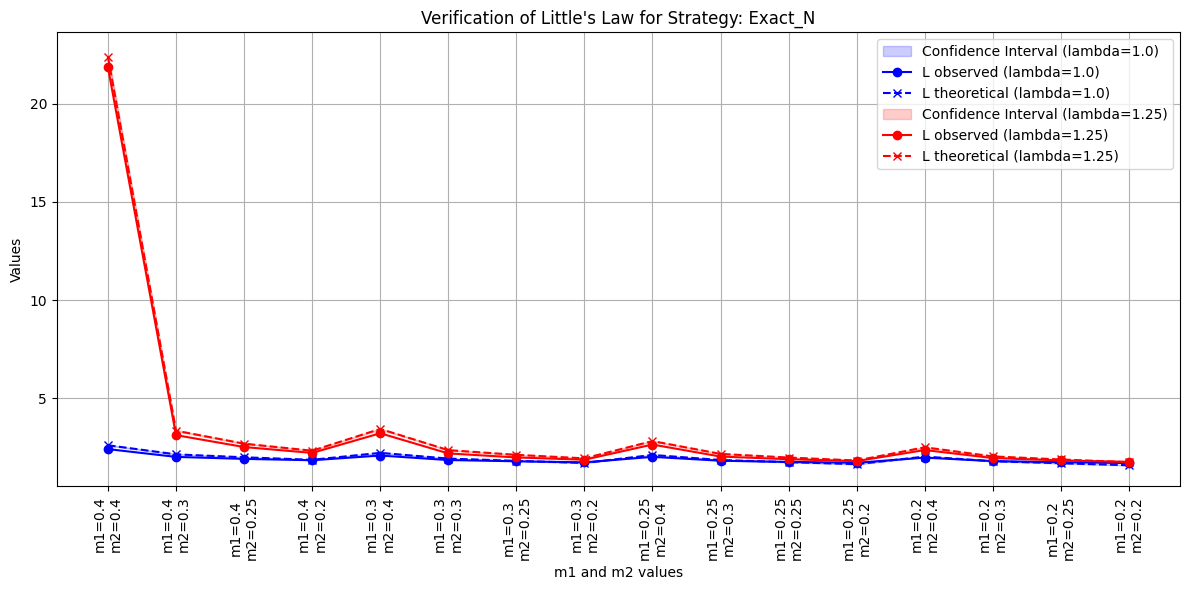

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


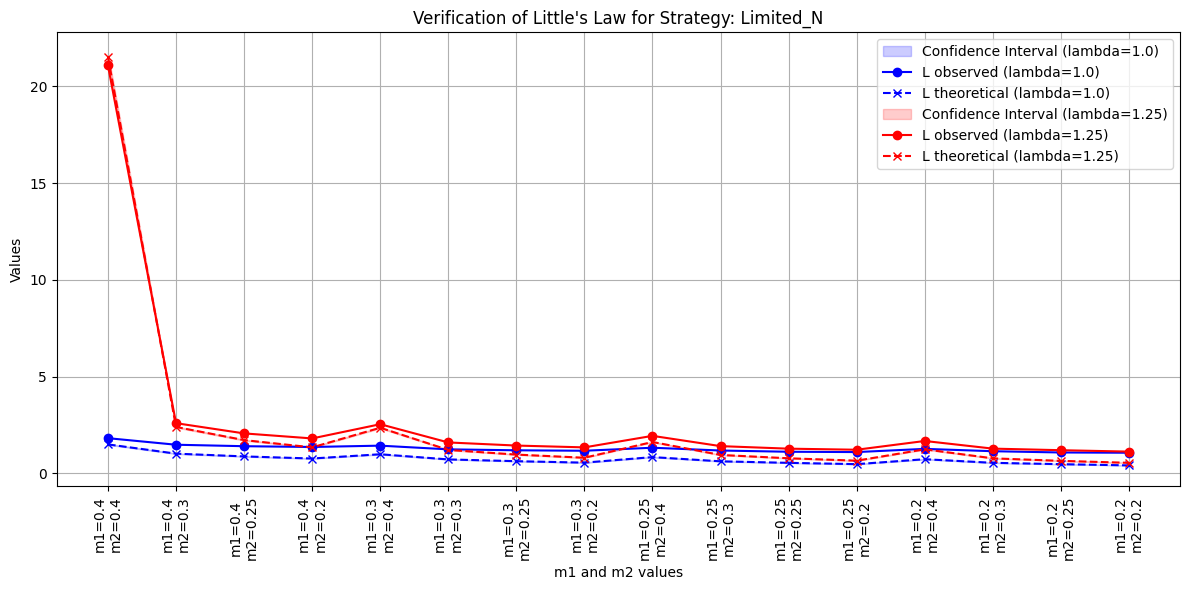

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


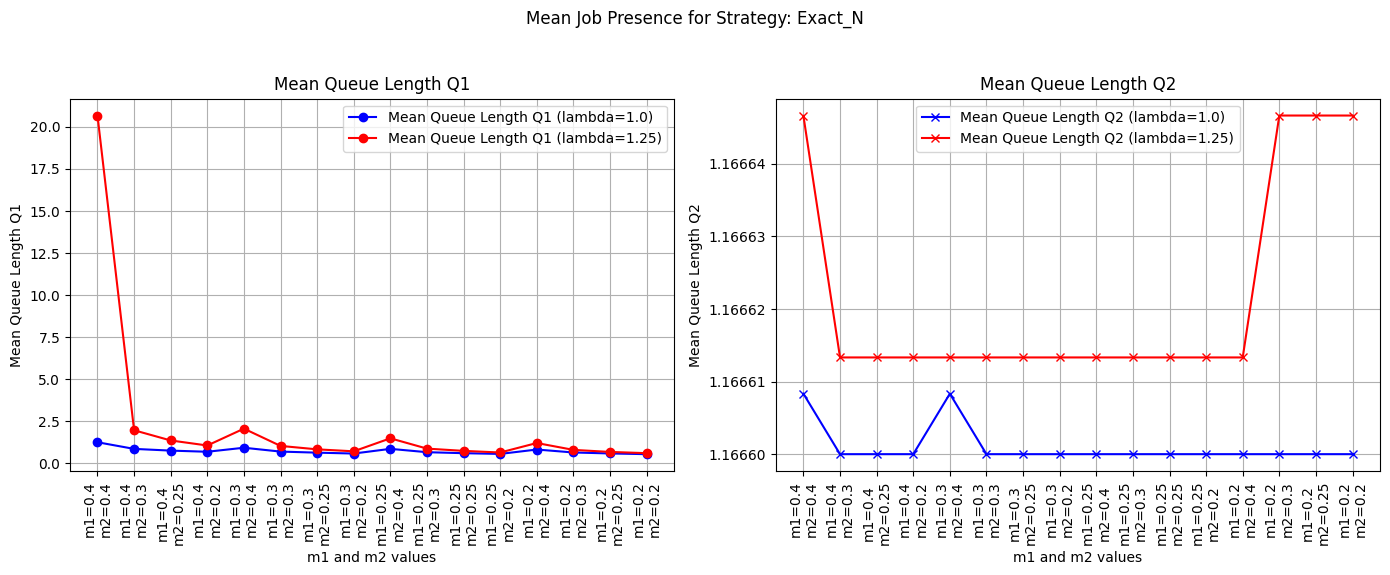

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


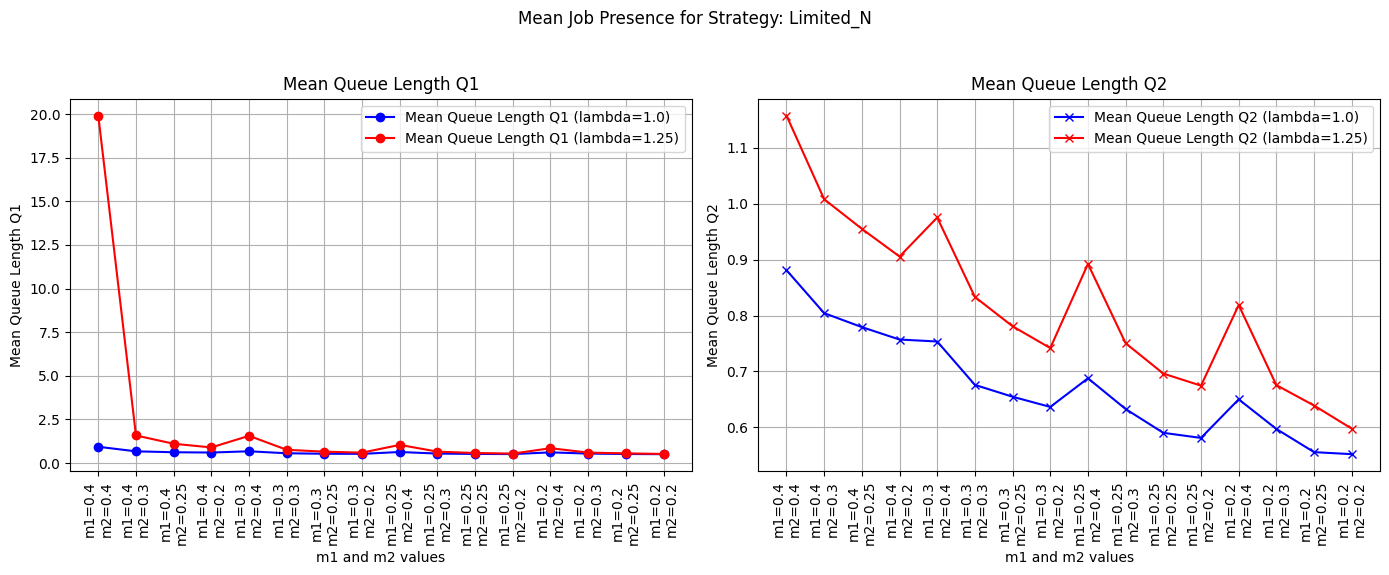

Utenti medi nel sistema per lambda=1.0: 1.5811872497600383
Utenti medi nel sistema per lambda=1.25: 3.1519607986132803
Presenza media in Q1: 1.4099733525585452
Presenza media in Q2: 0.9566006716281144
Presenza media in Q1 per lambda=1.0: 0.6606975371372756
Presenza media in Q2 per lambda=1.0: 0.9204897126227626
Presenza media in Q1 per lambda=1.25: 2.1592491679798145
Presenza media in Q2 per lambda=1.25: 0.992711630633466
Utenti medi nel sistema: 2.3665740241866597
Configurazioni che hanno passato il teorema di Little:
        File Strategy  lambda    m1    m2
52  Config53  Exact_N     1.0  0.25  0.25
58  Config59  Exact_N     1.0  0.20  0.30


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from matplotlib.ticker import ScalarFormatter

# Funzione per estrarre il valore di lambda dalla descrizione
def extract_lambda(description):
    match = re.search(r'lambda=([\d\.]+)', description)
    if match:
        return float(match.group(1))
    else:
        return None

# Funzione per estrarre i valori di m1 e m2 dalla descrizione
def extract_m_values(description):
    match_m1 = re.search(r'm1=([\d\.]+)', description)
    match_m2 = re.search(r'm2=([\d\.]+)', description)
    if match_m1 and match_m2:
        return float(match_m1.group(1)), float(match_m2.group(1))
    else:
        return None, None

# Funzione per convertire la stringa di tempi in una lista di float
def convert_lifetime(lifetime_str):
    return list(map(float, lifetime_str.split(',')))

# Carica i dati da results_summary_convalidation.csv
results_df = pd.read_csv('results_summary_convalidation_2.csv')

# Determina la strategia dalla descrizione
results_df['Strategy'] = results_df['Description'].apply(lambda desc: 'Exact_N' if 'Strategy=0' in desc else 'Limited_N')

# Estrai i valori di lambda, m1 e m2 dalla descrizione
results_df['lambda'] = results_df['Description'].apply(extract_lambda)
results_df[['m1', 'm2']] = results_df['Description'].apply(lambda desc: pd.Series(extract_m_values(desc)))

# Converte le stringhe di lifetime in liste di float
results_df['lifeTime'] = results_df['lifeTime'].apply(convert_lifetime)

# Calcola le colonne L osservato e L teorico usando le medie delle lunghezze delle code
results_df['L_observed'] = results_df['mean_queueLength_Q1'] + results_df['mean_queueLength_Q2']
results_df['L_theoretical'] = results_df['lambda'] * results_df['mean_W']
results_df['L_theoretical_low'] = results_df['lambda'] * results_df['ci_low_W']
results_df['L_theoretical_high'] = results_df['lambda'] * results_df['ci_high_W']
results_df['L_difference'] = abs(results_df['L_observed'] - results_df['L_theoretical'])
results_df['percentage_L_difference'] = (results_df['L_difference'] / results_df['L_observed']) * 100

# Calcola L_low e L_max per il teorema di Little
results_df['little_verification'] = results_df.apply(lambda row: row['L_theoretical_low'] <= row['L_observed'] <= row['L_theoretical_high'], axis=1)

# Salva i risultati in un file CSV
results_df.to_csv('LittleLaw_results.csv', index=False)

# Mostra i risultati per debug
print(results_df[['File', 'Strategy', 'lambda', 'm1', 'm2', 'mean_W', 'ci_low_W', 'ci_high_W', 'L_observed', 'L_theoretical', 'L_theoretical_low', 'L_theoretical_high', 'L_difference', 'percentage_L_difference', 'little_verification']])

# Grafico per verificare il teorema di Little per tutte le configurazioni con politiche Limited_N ed Exact_N
strategies = ['Exact_N', 'Limited_N']
lambda_colors = {1.0: 'blue', 1.25: 'red'}

for strategy in strategies:
    subset = results_df[results_df['Strategy'] == strategy]
    if not subset.empty:
        plt.figure(figsize=(12, 6))
        for lambda_value, color in lambda_colors.items():
            subsubset = subset[subset['lambda'] == lambda_value]
            if not subsubset.empty:
                x_values = subsubset.apply(lambda row: f"m1={row['m1']}\nm2={row['m2']}", axis=1)
                plt.fill_between(np.arange(len(x_values)), subsubset['L_theoretical_low'], subsubset['L_theoretical_high'], color=color, alpha=0.2, label=f'Confidence Interval (lambda={lambda_value})')
                plt.plot(np.arange(len(x_values)), subsubset['L_observed'], marker='o', linestyle='-', color=color, label=f'L observed (lambda={lambda_value})')
                plt.plot(np.arange(len(x_values)), subsubset['L_theoretical'], marker='x', linestyle='--', color=color, label=f'L theoretical (lambda={lambda_value})')
        plt.xticks(np.arange(len(x_values)), x_values, rotation=90)
        plt.xlabel('m1 and m2 values')
        plt.ylabel('Values')
        plt.title(f'Verification of Little\'s Law for Strategy: {strategy}')
        plt.legend()
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
        plt.tight_layout()
        plt.savefig(f'Convalidation_2_Images/LittleLaw_{strategy}.png')
        plt.savefig(f'Convalidation_2_Images/LittleLaw_{strategy}.eps')  
        plt.show()

# Grafico della presenza media di job nel sistema per le due code
for strategy in strategies:
    subset = results_df[results_df['Strategy'] == strategy]
    if not subset.empty:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        for lambda_value, color in lambda_colors.items():
            subsubset = subset[subset['lambda'] == lambda_value]
            if not subsubset.empty:
                x_values = subsubset.apply(lambda row: f"m1={row['m1']}\nm2={row['m2']}", axis=1)
                
                ax1.plot(np.arange(len(x_values)), subsubset['mean_queueLength_Q1'], marker='o', linestyle='-', color=color, label=f'Mean Queue Length Q1 (lambda={lambda_value})')
                ax1.set_xticks(np.arange(len(x_values)))
                ax1.set_xticklabels(x_values, rotation=90)
                ax1.set_xlabel('m1 and m2 values')
                ax1.set_ylabel('Mean Queue Length Q1')
                ax1.set_title('Mean Queue Length Q1')
                ax1.legend()
                ax1.grid(True)
                ax1.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
                
                ax2.plot(np.arange(len(x_values)), subsubset['mean_queueLength_Q2'], marker='x', linestyle='-', color=color, label=f'Mean Queue Length Q2 (lambda={lambda_value})')
                ax2.set_xticks(np.arange(len(x_values)))
                ax2.set_xticklabels(x_values, rotation=90)
                ax2.set_xlabel('m1 and m2 values')
                ax2.set_ylabel('Mean Queue Length Q2')
                ax2.set_title('Mean Queue Length Q2')
                ax2.legend()
                ax2.grid(True)
                ax2.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

        fig.suptitle(f'Mean Job Presence for Strategy: {strategy}')
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
        plt.savefig(f'Convalidation_2_Images/Mean_Job_Presence_{strategy}.png')
        plt.savefig(f'Convalidation_2_Images/Mean_Job_Presence_{strategy}.eps')  
        plt.show()

# Calcolo degli utenti medi per lambda 1.0 e 1.25
mean_users_lambda_1_0 = results_df[results_df['lambda'] == 1.0]['L_observed'].mean()
mean_users_lambda_1_25 = results_df[results_df['lambda'] == 1.25]['L_observed'].mean()

print(f"Utenti medi nel sistema per lambda=1.0: {mean_users_lambda_1_0}")
print(f"Utenti medi nel sistema per lambda=1.25: {mean_users_lambda_1_25}")

# Calcolo della presenza media in Q1 e Q2 globalmente
mean_presence_Q1 = results_df['mean_queueLength_Q1'].mean()
mean_presence_Q2 = results_df['mean_queueLength_Q2'].mean()

# Calcolo della presenza media in Q1 e Q2 per lambda 1.0 e 1.25
mean_presence_Q1_lambda_1_0 = results_df[results_df['lambda'] == 1.0]['mean_queueLength_Q1'].mean()
mean_presence_Q2_lambda_1_0 = results_df[results_df['lambda'] == 1.0]['mean_queueLength_Q2'].mean()
mean_presence_Q1_lambda_1_25 = results_df[results_df['lambda'] == 1.25]['mean_queueLength_Q1'].mean()
mean_presence_Q2_lambda_1_25 = results_df[results_df['lambda'] == 1.25]['mean_queueLength_Q2'].mean()

print(f"Presenza media in Q1: {mean_presence_Q1}")
print(f"Presenza media in Q2: {mean_presence_Q2}")
print(f"Presenza media in Q1 per lambda=1.0: {mean_presence_Q1_lambda_1_0}")
print(f"Presenza media in Q2 per lambda=1.0: {mean_presence_Q2_lambda_1_0}")
print(f"Presenza media in Q1 per lambda=1.25: {mean_presence_Q1_lambda_1_25}")
print(f"Presenza media in Q2 per lambda=1.25: {mean_presence_Q2_lambda_1_25}")

# Calcola gli utenti medi nel sistema
mean_users = results_df['L_observed'].mean()
print(f"Utenti medi nel sistema: {mean_users}")

# Configurazioni che hanno passato il teorema di Little
little_law_passed = results_df[results_df['little_verification']]

print("Configurazioni che hanno passato il teorema di Little:")
print(little_law_passed[['File', 'Strategy', 'lambda', 'm1', 'm2']])


In [4]:
import pandas as pd
import numpy as np
import re
import scipy.stats as stats

# Funzione per estrarre il valore di lambda dalla descrizione
def extract_lambda(description):
    match = re.search(r'lambda=([\d\.]+)', description)
    if match:
        return float(match.group(1))
    else:
        return None

# Funzione per estrarre i valori di m1 e m2 dalla descrizione
def extract_m_values(description):
    match_m1 = re.search(r'm1=([\d\.]+)', description)
    match_m2 = re.search(r'm2=([\d\.]+)', description)
    if match_m1 and match_m2:
        return float(match_m1.group(1)), float(match_m2.group(1))
    else:
        return None, None

# Funzione per convertire la stringa di tempi in una lista di float
def convert_lifetime(lifetime_str):
    return list(map(float, lifetime_str.split(',')))

# Funzione per calcolare l'intervallo di confidenza con distribuzione normale
def normal_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std_error = stats.sem(data)
    z_value = stats.norm.ppf(1 - (1 - confidence) / 2)
    margin = z_value * std_error
    return mean, mean - margin, mean + margin

# Carica i dati da results_summary_convalidation.csv
results_df = pd.read_csv('results_summary_convalidation_2.csv')

# Determina la strategia dalla descrizione
results_df['Strategy'] = results_df['Description'].apply(lambda desc: 'Exact_N' if 'Strategy=0' in desc else 'Limited_N')

# Filtra solo le configurazioni per N_Limited
results_df = results_df[results_df['Strategy'] == 'Limited_N']

# Estrai i valori di lambda, m1 e m2 dalla descrizione
results_df['lambda'] = results_df['Description'].apply(extract_lambda)
results_df[['m1', 'm2']] = results_df['Description'].apply(lambda desc: pd.Series(extract_m_values(desc)))

# Converte le stringhe di lifetime in liste di float
results_df['lifeTime'] = results_df['lifeTime'].apply(convert_lifetime)

# Calcola le colonne L osservato
results_df['L_observed'] = results_df['mean_queueLength_Q1'] + results_df['mean_queueLength_Q2']

# Funzione per creare le tabelle di verifica del teorema di Little per ogni intervallo di confidenza
def create_little_law_table(df, conf_label, method):
    if method == 't_student':
        mean_col = f'mean_W_t_student_{conf_label}'
        low_col = f'ci_low_W_t_student_{conf_label}'
        high_col = f'ci_high_W_t_student_{conf_label}'
    elif method == 'naive':
        mean_col = f'mean_W_naive_{conf_label}'
        low_col = f'ci_low_W_naive_{conf_label}'
        high_col = f'ci_high_W_naive_{conf_label}'
    elif method == 'normal':
        mean_col = f'mean_W_normal_{conf_label}'
        low_col = f'ci_low_W_normal_{conf_label}'
        high_col = f'ci_high_W_normal_{conf_label}'
    
    table_df = df[['File', 'lambda', 'm1', 'm2', mean_col, low_col, high_col, 'L_observed']]
    table_df = table_df.rename(columns={
        mean_col: f'L_theoretical_{conf_label}',
        low_col: f'L_theoretical_low_{conf_label}',
        high_col: f'L_theoretical_high_{conf_label}'
    })
    table_df[f'L_theoretical_{conf_label}'] = table_df['lambda'] * table_df[f'L_theoretical_{conf_label}']
    table_df[f'L_theoretical_low_{conf_label}'] = table_df['lambda'] * table_df[f'L_theoretical_low_{conf_label}']
    table_df[f'L_theoretical_high_{conf_label}'] = table_df['lambda'] * table_df[f'L_theoretical_high_{conf_label}']
    table_df['little_verification'] = table_df.apply(lambda row: row[f'L_theoretical_low_{conf_label}'] <= row['L_observed'] <= row[f'L_theoretical_high_{conf_label}'], axis=1)
    table_df['Verification'] = table_df['little_verification'].apply(lambda x: 'X' if x else '')
    return table_df[['File', 'lambda', 'm1', 'm2', f'L_theoretical_{conf_label}', 'L_observed', f'L_theoretical_low_{conf_label}', f'L_theoretical_high_{conf_label}', 'Verification']]

# Crea le tabelle per ogni intervallo di confidenza per tutti i metodi
conf_levels = [95, 90, 85, 80]
tables_t_student = {}
tables_naive = {}
tables_normal = {}

for conf in conf_levels:
    conf_label = f'{conf}'
    tables_t_student[conf_label] = create_little_law_table(results_df, conf_label, 't_student')
    tables_naive[conf_label] = create_little_law_table(results_df, conf_label, 'naive')
    tables_normal[conf_label] = create_little_law_table(results_df, conf_label, 'normal')

# Salva ogni tabella in un file CSV separato per tutti i metodi
for conf_label, table in tables_t_student.items():
    table.to_csv(f'LittleLaw_verification_table_t_student_{conf_label}.csv', index=False)
    print(f"\nTabella per l'intervallo di confidenza {conf_label}% (t-student):")
    print(table)

for conf_label, table in tables_naive.items():
    table.to_csv(f'LittleLaw_verification_table_naive_{conf_label}.csv', index=False)
    print(f"\nTabella per l'intervallo di confidenza {conf_label}% (naive):")
    print(table)

for conf_label, table in tables_normal.items():
    table.to_csv(f'LittleLaw_verification_table_normal_{conf_label}.csv', index=False)
    print(f"\nTabella per l'intervallo di confidenza {conf_label}% (normale):")
    print(table)

# Aggiungi il calcolo dell'intervallo di confidenza con distribuzione normale ai risultati
for conf in conf_levels:
    conf_label = f'{conf}'
    results_df[f'mean_W_normal_{conf_label}'] = results_df['lifeTime'].apply(lambda x: normal_confidence_interval(x, confidence=conf/100)[0])
    results_df[f'ci_low_W_normal_{conf_label}'] = results_df['lifeTime'].apply(lambda x: normal_confidence_interval(x, confidence=conf/100)[1])
    results_df[f'ci_high_W_normal_{conf_label}'] = results_df['lifeTime'].apply(lambda x: normal_confidence_interval(x, confidence=conf/100)[2])

# Salva il DataFrame con i nuovi calcoli
results_df.to_csv('results_summary_convalidation_2_with_normal.csv', index=False)

# Esempio di utilizzo
directory_path = './results_CSV_convalidation_2'
analyze_directory(directory_path)



Tabella per l'intervallo di confidenza 95% (t-student):
        File  lambda    m1    m2  L_theoretical_95  L_observed  \
1    Config2    1.25  0.40  0.40         21.514242   21.072197   
3    Config4    1.25  0.40  0.30          2.394172    2.590469   
5    Config6    1.25  0.40  0.25          1.715808    2.062406   
7    Config8    1.25  0.40  0.20          1.339759    1.801748   
9   Config10    1.25  0.30  0.40          2.354075    2.536445   
11  Config12    1.25  0.30  0.30          1.208353    1.594586   
13  Config14    1.25  0.30  0.25          0.967561    1.434016   
15  Config16    1.25  0.30  0.20          0.804645    1.339657   
17  Config18    1.25  0.25  0.40          1.618485    1.935206   
19  Config20    1.25  0.25  0.30          0.948545    1.404460   
21  Config22    1.25  0.25  0.25          0.776950    1.273289   
23  Config24    1.25  0.25  0.20          0.653142    1.218157   
25  Config26    1.25  0.20  0.40          1.239884    1.670436   
27  Config28    1.2

In [5]:
import pandas as pd

# Funzione per troncare i valori al terzo decimale e salvare le colonne richieste
def truncate_and_save_csv(file_path):
    # Leggi il file CSV
    df = pd.read_csv(file_path)
    
    # Seleziona le colonne dalla 5 alla 9 (0-indexed, quindi dalla colonna 4 alla colonna 8)
    df_selected = df.iloc[:, 4:9]
    
    # Tronca i valori al terzo decimale
    df_truncated = df_selected.round(3)
    
    # Genera il nuovo nome del file
    new_file_path = file_path.replace('.csv', '_truncated.csv')
    
    # Salva il nuovo file CSV
    df_truncated.to_csv(new_file_path, index=False)
    
    return new_file_path

# Funzione per elaborare tutti i file CSV di verifica del teorema di Little
def process_little_law_verification_files():
    conf_levels = [95, 90, 85, 80]
    methods = ['t_student', 'naive', 'normal']
    
    for method in methods:
        for conf in conf_levels:
            conf_label = f'{conf}'
            file_path = f'LittleLaw_verification_table_{method}_{conf_label}.csv'
            new_file_path = truncate_and_save_csv(file_path)
            print(f"Generato file troncato: {new_file_path}")

# Esegui l'elaborazione dei file
process_little_law_verification_files()


Generato file troncato: LittleLaw_verification_table_t_student_95_truncated.csv
Generato file troncato: LittleLaw_verification_table_t_student_90_truncated.csv
Generato file troncato: LittleLaw_verification_table_t_student_85_truncated.csv
Generato file troncato: LittleLaw_verification_table_t_student_80_truncated.csv
Generato file troncato: LittleLaw_verification_table_naive_95_truncated.csv
Generato file troncato: LittleLaw_verification_table_naive_90_truncated.csv
Generato file troncato: LittleLaw_verification_table_naive_85_truncated.csv
Generato file troncato: LittleLaw_verification_table_naive_80_truncated.csv
Generato file troncato: LittleLaw_verification_table_normal_95_truncated.csv
Generato file troncato: LittleLaw_verification_table_normal_90_truncated.csv
Generato file troncato: LittleLaw_verification_table_normal_85_truncated.csv
Generato file troncato: LittleLaw_verification_table_normal_80_truncated.csv
